<a href="https://colab.research.google.com/github/dtabuena/Ephys_DataSets/blob/main/Analyze_BMX_HEK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',

            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.7 MB/s eta 0:00:00
Cloning into 'EphysLib'...
remote: Enumerating objects: 1141, done.
remote: Counting objects: 100% (518/518), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 1141 (delta 377), reused 359 (delta 271), pack-reused 623
Receiving objects: 100% (1141/1141), 17.41 MiB | 2.88 MiB/s, done.
Resolving deltas: 100% (754/754), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00


In [3]:
### quick import
import urllib
import json
import matplotlib as mpl
from matplotlib import rcParams
def import_mpl_config(FS=6):
    """ Load my default plotting parameters """
    if os.path.isfile(f'./mpl_config_FS{FS}.json'):
        os.remove(f'./mpl_config_FS{FS}.json')
    _ = urllib.request.urlretrieve('https://github.com/dtabuena/Resources/'\
                                   'raw//main/Matplotlib_Config/'\
                                   f'mpl_config_FS{FS}.json',
                                   f'mpl_config_FS{FS}.json')
    with open(f"./mpl_config_FS{FS}.json",'r') as import_file:
        fig_config = json.load(import_file)
    rcParams.update(fig_config)
    _ = urllib.request.urlretrieve('https://github.com/dtabuena/Resources/raw/main/Fonts/arial.ttf','arial.ttf')
    mpl.font_manager.fontManager.addfont('arial.ttf')
    return fig_config
_ = import_mpl_config()

In [4]:
import urllib
file_name,_ = urllib.request.urlretrieve('https://www.dropbox.com/scl/fi/1yg80je83aqr68berui86/Before_After.csv?rlkey=k9pacq5t9u9icu1nkcnrhoad6&dl=1','before_after.csv')
doses_df = pd.read_csv(file_name).set_index('Cell')
display(doses_df.head(15))

,Before IV,During,After IV
Cell,,,
2023x12x13_SLICK_c001_HEK,2023x12x13_SLICK_c001_HEK_0002,2023x12x13_SLICK_c001_HEK_0003,2023x12x13_SLICK_c001_HEK_0004
2023x12x13_SLICK_c002_HEK,2023x12x13_SLICK_c002_HEK_0004,2023x12x13_SLICK_c002_HEK_0006,2023x12x13_SLICK_c002_HEK_0008
2023x12x14_SLICK_c001_HEK,2023x12x14_SLICK_c001_HEK_0000,2023x12x14_SLICK_c001_HEK_0002,2023x12x14_SLICK_c001_HEK_0003
2023x12x15_SLICK_c001_HEK,2023x12x15_SLICK_c001_HEK_0003,2023x12x15_SLICK_c001_HEK_0004,2023x12x15_SLICK_c001_HEK_0005
2023x12x15_SLICK_c002_HEK,2023x12x15_SLICK_c002_HEK_0002,2023x12x15_SLICK_c002_HEK_0003,2023x12x15_SLICK_c002_HEK_0004
2023x12x15_SLICK_c003_HEK,2023x12x15_SLICK_c003_HEK_0001,2023x12x15_SLICK_c003_HEK_0002,2023x12x15_SLICK_c003_HEK_0003
2023x12x15_SLICK_c005_HEK,2023x12x15_SLICK_c005_HEK_0002,2023x12x15_SLICK_c005_HEK_0003,2023x12x15_SLICK_c005_HEK_0005
2023x12x15_SLICK_c006_HEK,2023x12x15_SLICK_c006_HEK_0002,2023x12x15_SLICK_c006_HEK_0004,2023x12x15_SLICK_c006_HEK_0007
2023x12x15_SLICK_c007_HEK,2023x12x15_SLICK_c007_HEK_0001,2023x12x15_SLICK_c007_HEK_0003,2023x12x15_SLICK_c007_HEK_0005


In [5]:
dataset = {'data_name': 'BMX',
           'data_source': "https://www.dropbox.com/scl/fo/2ps1mdb88490cgol95l3u/h?rlkey=trp33s4fhrl4pyg4h4k0jecwh&dl=1",
           'file_naming_scheme': ['Rec_date','GenoType','Cell_num','Cell_Type'],
           }
##2023x12x13_SLICK_c001_HEK_0001
data_name = dataset['data_name']
data_source = dataset['data_source']
file_naming_scheme = dataset['file_naming_scheme']

''' Gather and Catalog Source Data'''
file_loc = get_drobox_folder_url(data_source, 'my_ephys_data_' + data_name)
clear_output(wait=False)
abf_recordings_df, protocol_set = catalogue_recs(file_loc,file_naming_scheme)
print(protocol_set)

['VC - MemTest-10ms-160ms', 'K_total', 'K_total_Run']


In [6]:
if not os.path.exists('figs'): os.makedirs('figs')

In [7]:
from sklearn import linear_model

def measure_slick(abf,duration_ms = 10,to_plot=True):
    i_chan = 0
    duration_indx = int(duration_ms/1000*abf.sampleRate)
    measure_epoch = get_epoch(abf,epoch=3)
    stop_idx = measure_epoch['index']["stop"]
    start_idx = stop_idx - duration_indx
    # if 2 in abf.channelList: i_chan = 2
    I,V,T = analyze_currents(abf,start_idx,stop_idx,i_chan=i_chan)
    return {'Ik':I,'Vm':V,'SweepTimes':T}

def get_epoch(abf,epoch=3):
    results={"epoch":epoch}
    results={"index":{"start":abf.sweepEpochs.p1s[epoch],
                      "stop":abf.sweepEpochs.p1s[epoch+1]}}
    return results

def analyze_currents(abf,start_idx,stop_idx,analysis_function=np.median,i_chan=0,v_chan=1):
    I = list()
    V = list()
    for s in abf.sweepList:
        abf.setSweep(s,channel=i_chan)
        I.append(analysis_function(abf.sweepY[start_idx:stop_idx]))
        abf.setSweep(s,channel=v_chan)
        V.append(analysis_function(abf.sweepY[start_idx:stop_idx]))
    V = [int(10*np.round(v/10,0)) for v in V]
    return I,V,list(abf.sweepTimesSec)


def linear_leak_correction(sweep_results,v_range=(-90,-30)):
    Vm = np.array(sweep_results['Vm'])[:,np.newaxis]
    I = np.array(sweep_results['Ik'])[:,np.newaxis]
    fit_ind = [i for i,v in enumerate(Vm) if v >= np.min(v_range) and v<= np.max(v_range) ]
    if len(fit_ind)<2:
        sweep_results['I_leak'] = I*np.nan
        sweep_results['Ik_corr'] =I*np.nan
        return sweep_results
    x = Vm[fit_ind]
    y = I[fit_ind]
    leak_model = linear_model.LinearRegression().fit(x,y)
    leak_pred  = leak_model.predict(Vm)
    corrected_I = I - leak_pred
    corrected_I = [float(c) for c in corrected_I]
    sweep_results['I_leak'] = leak_pred
    sweep_results['Ik_corr'] =corrected_I
    return sweep_results


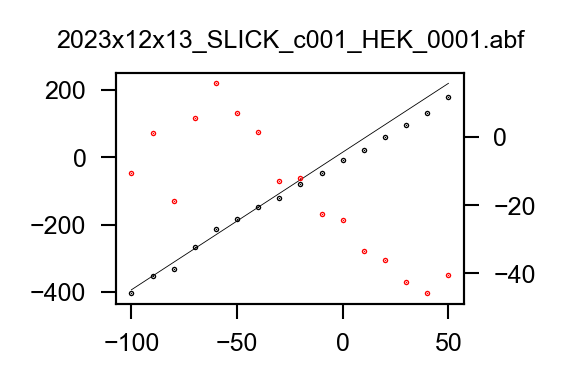

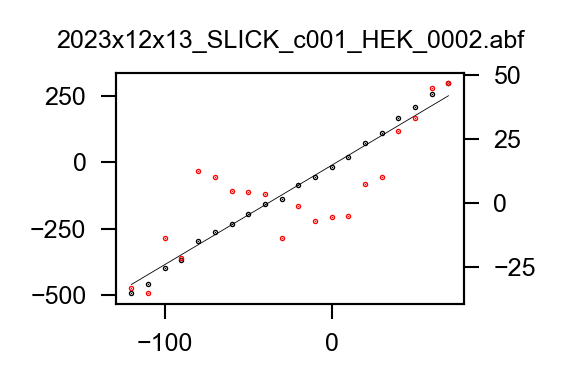

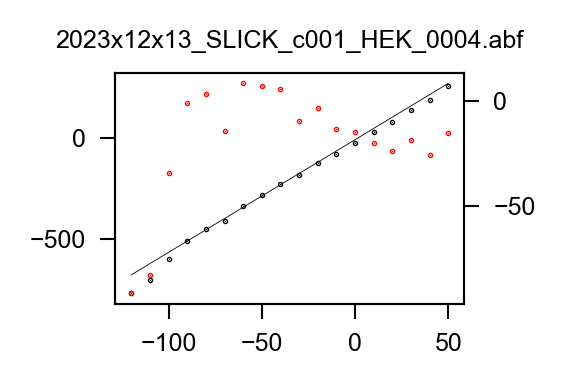

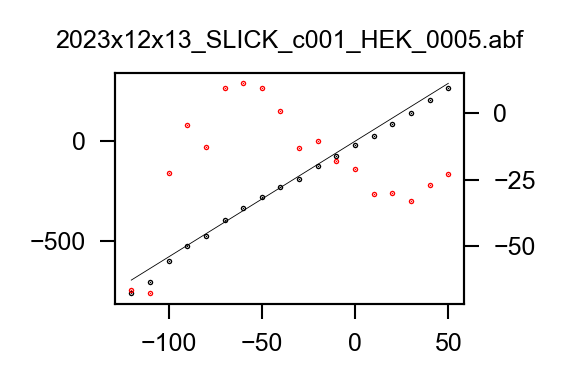

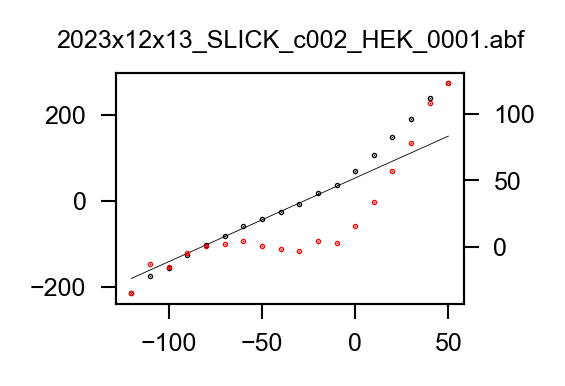

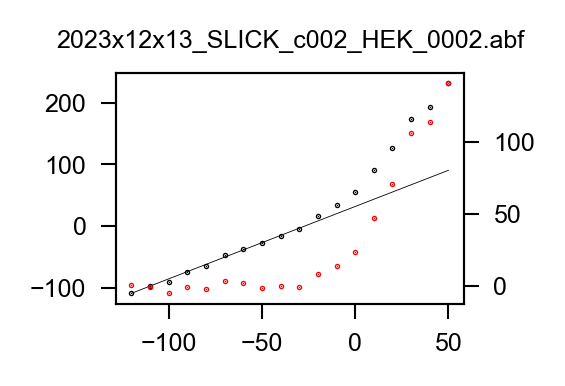

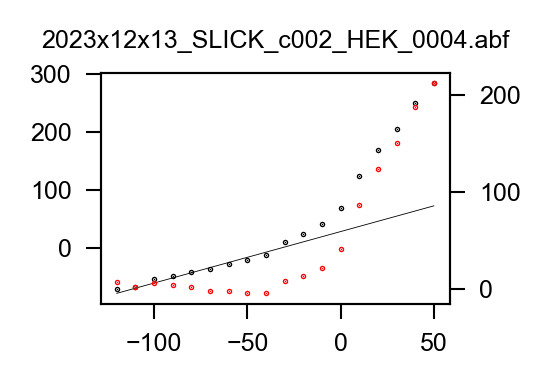

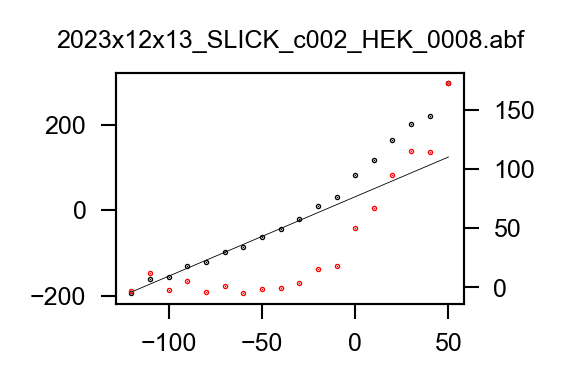

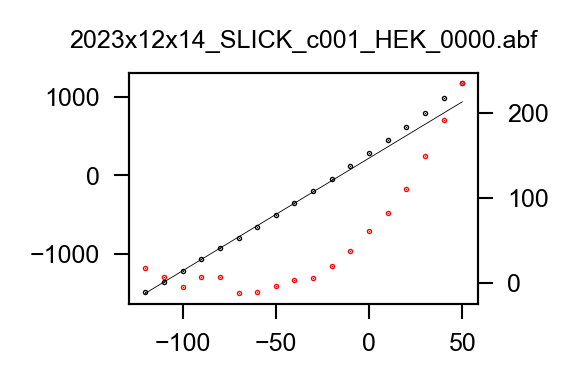

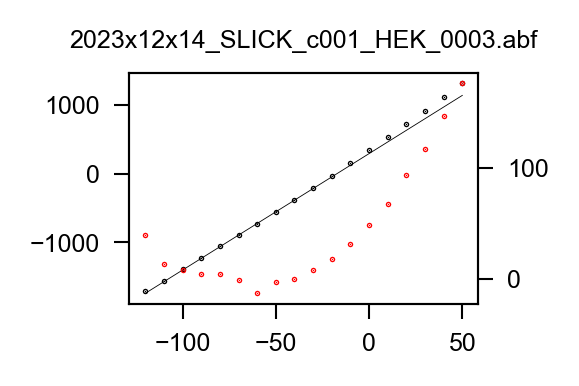

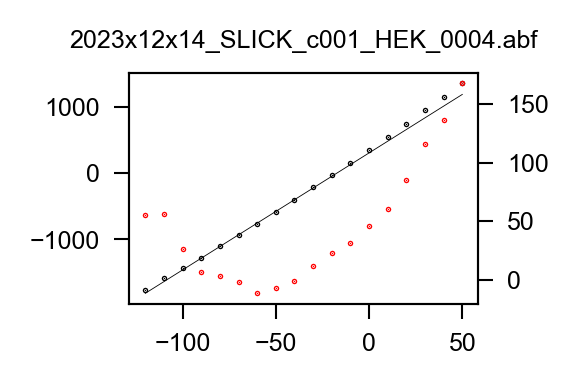

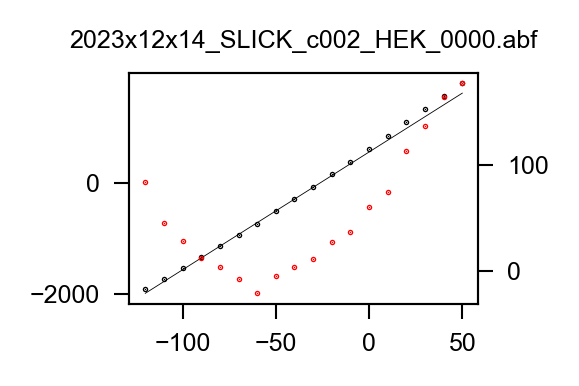

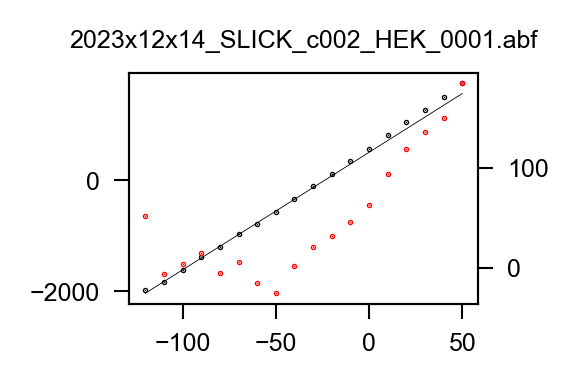

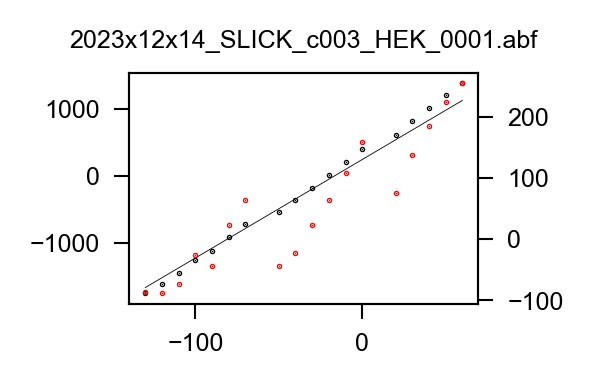

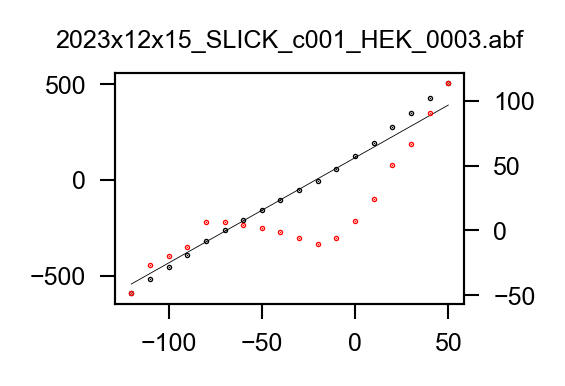

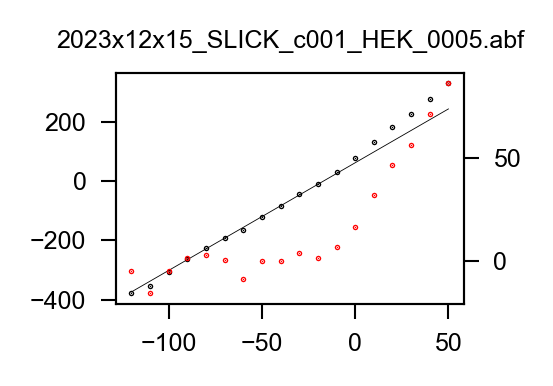

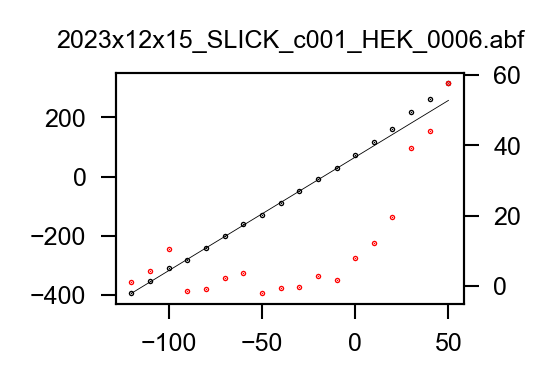

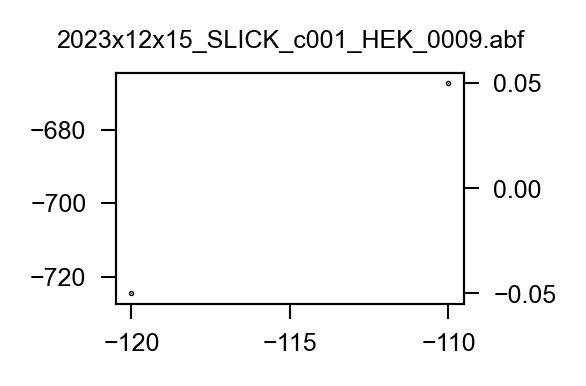

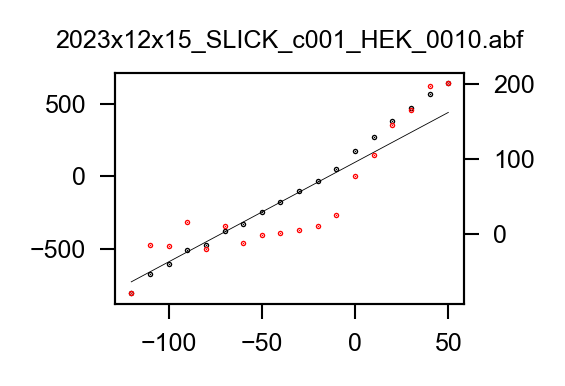

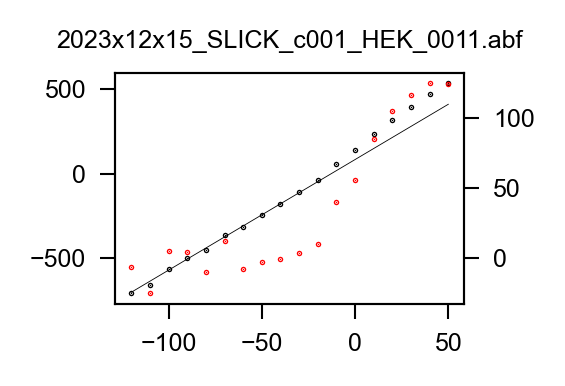

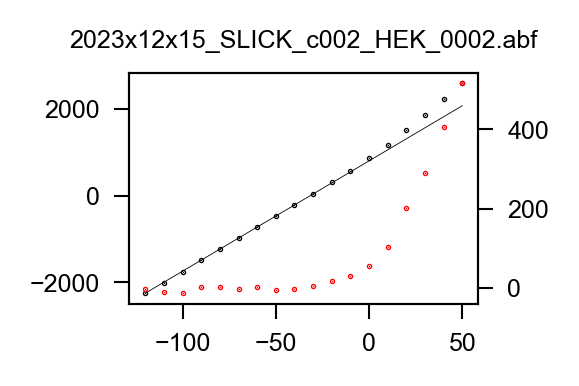

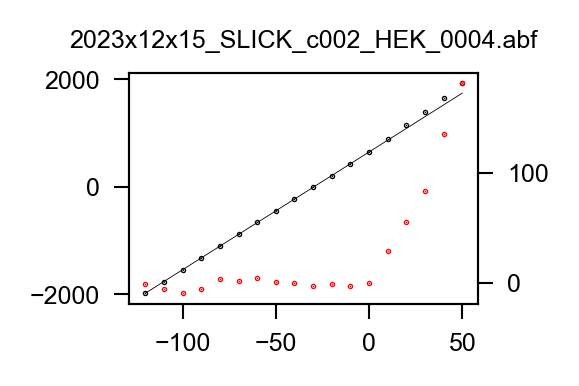

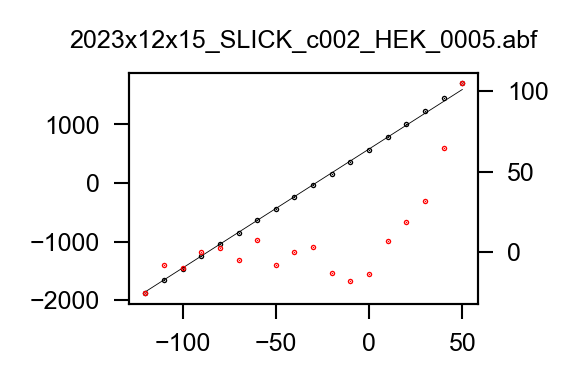

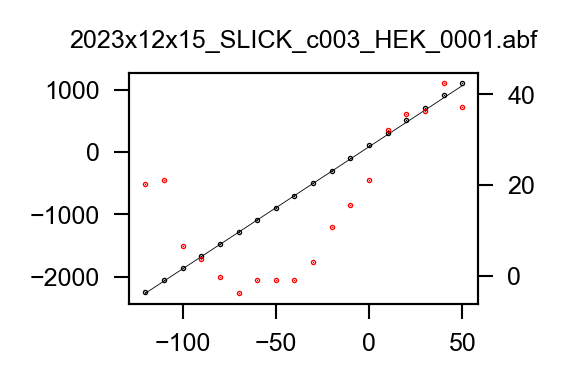

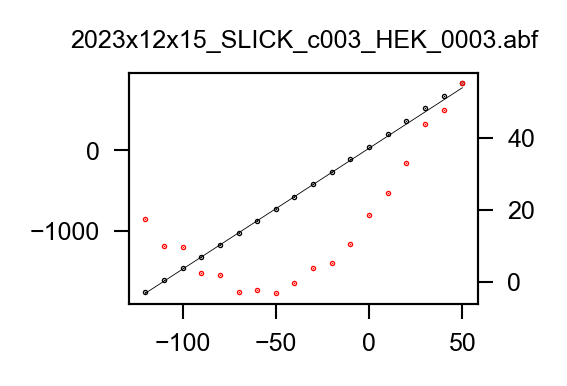

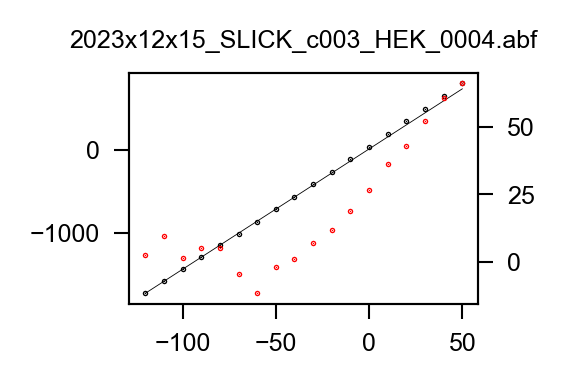

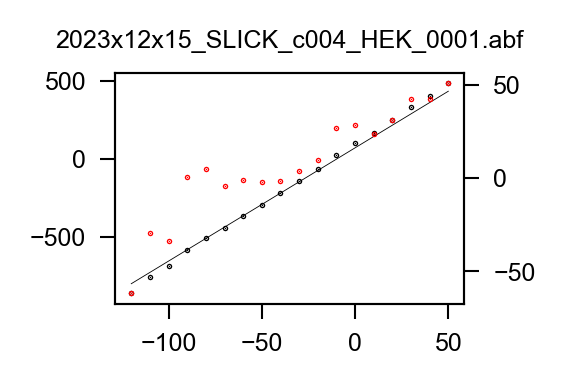

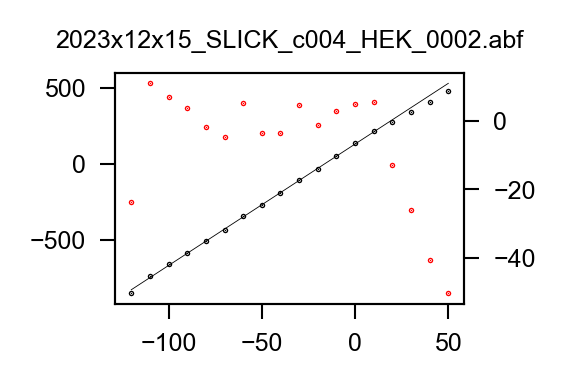

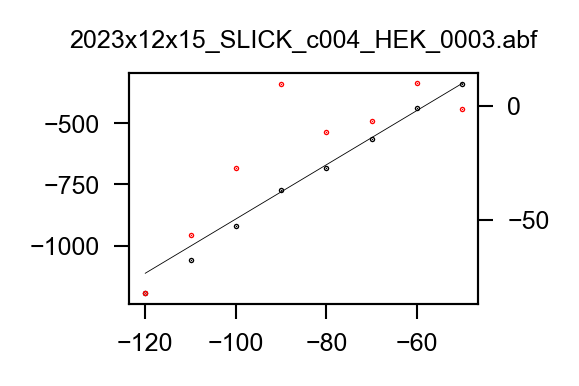

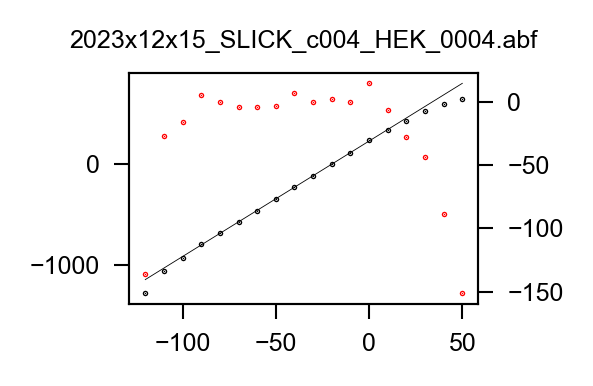

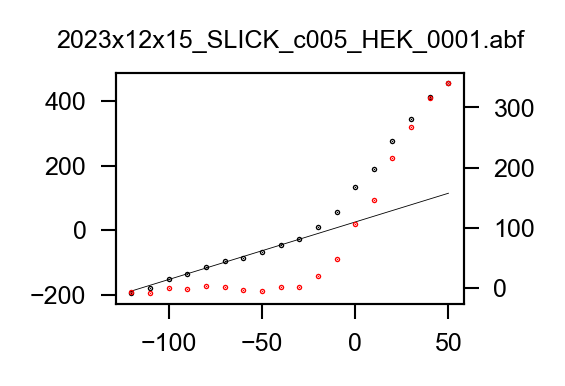

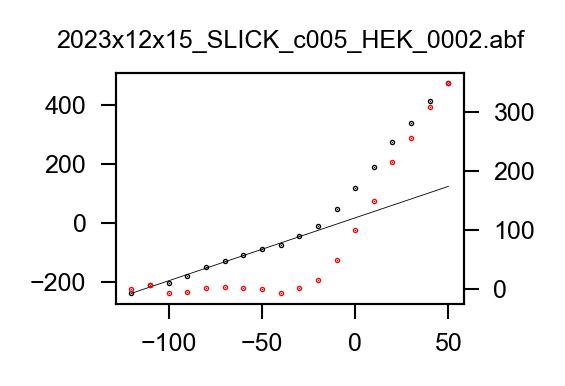

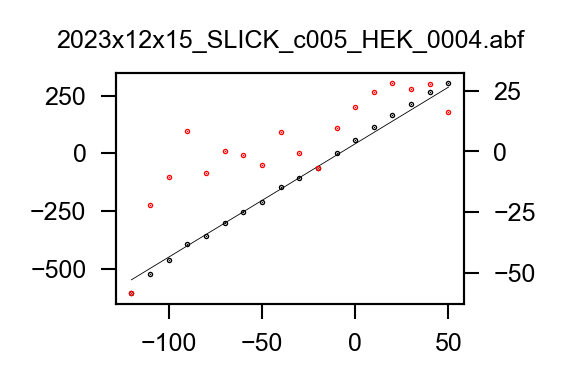

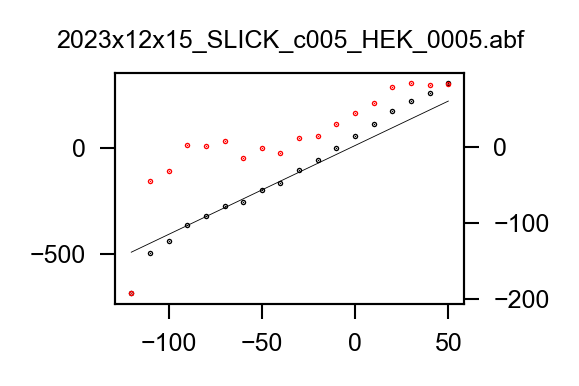

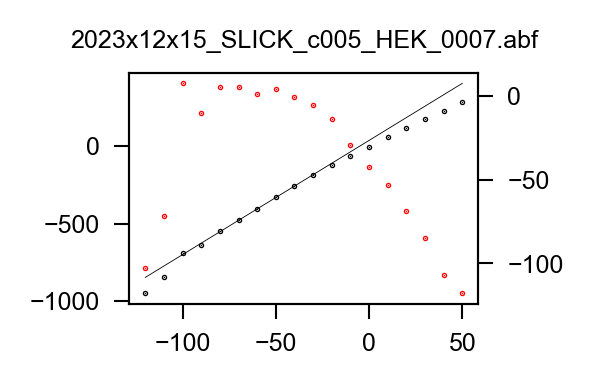

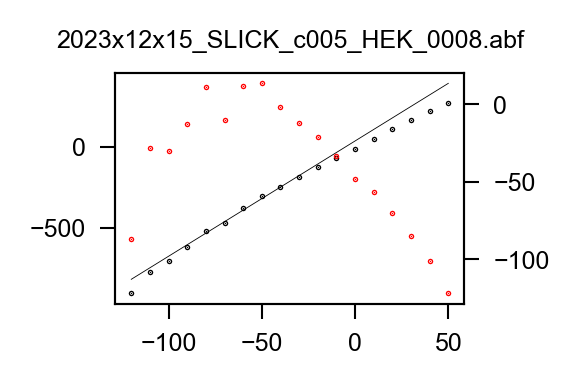

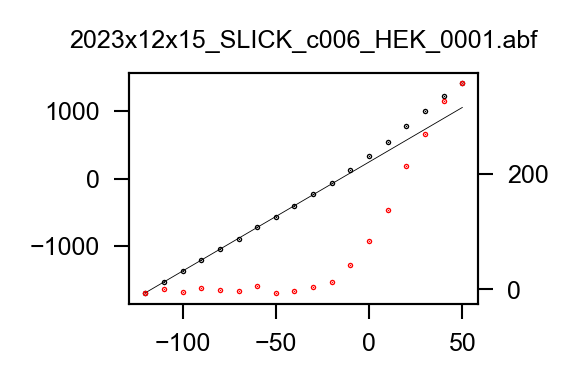

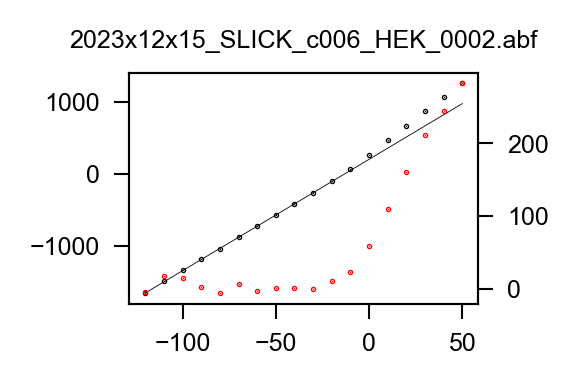

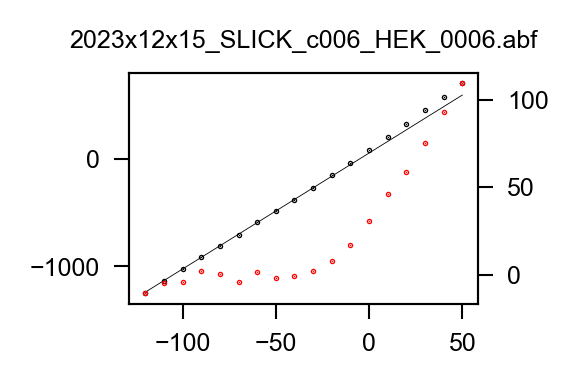

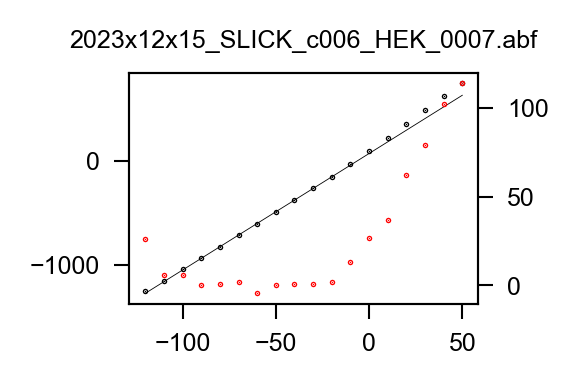

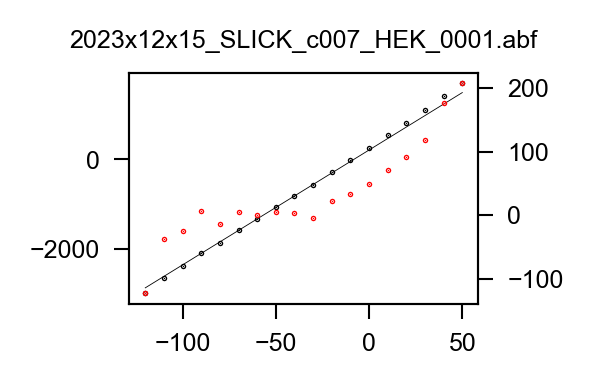

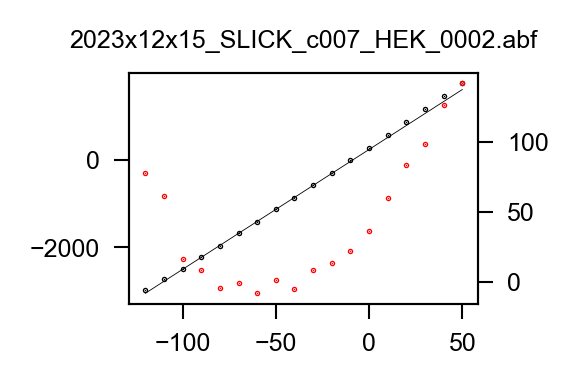

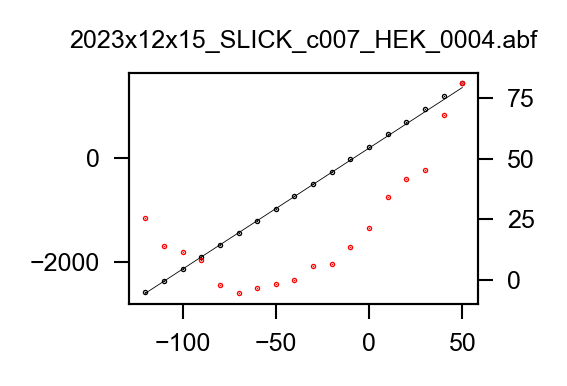

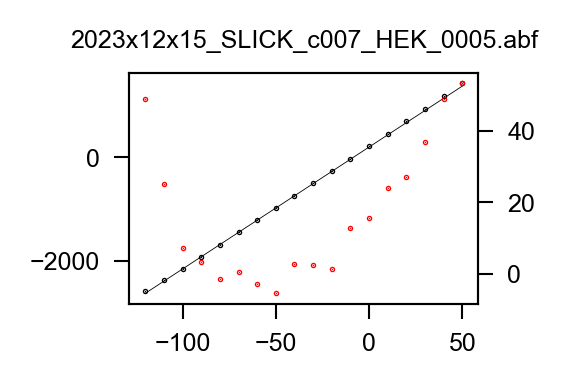

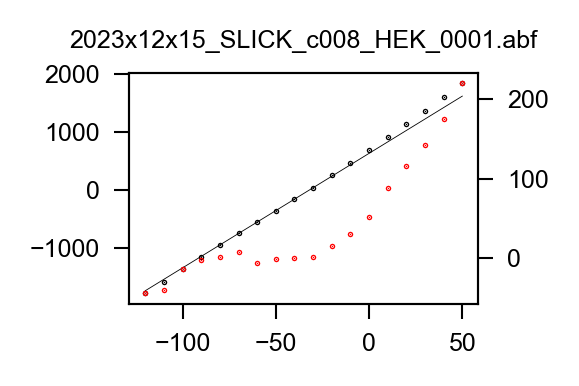

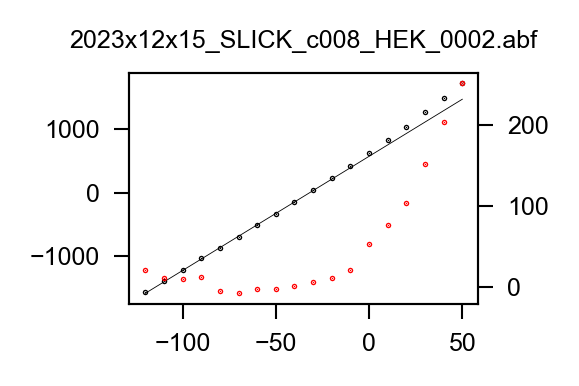

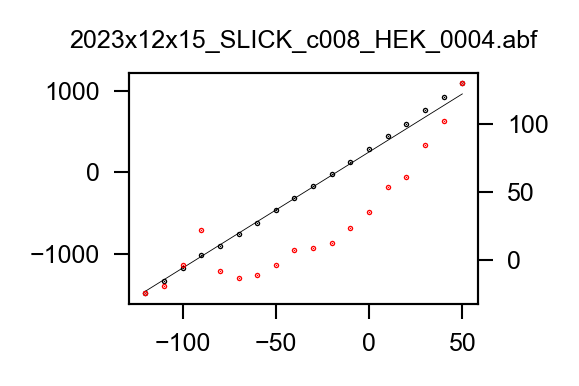

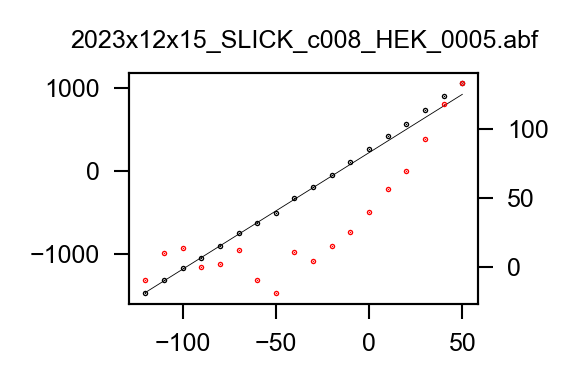

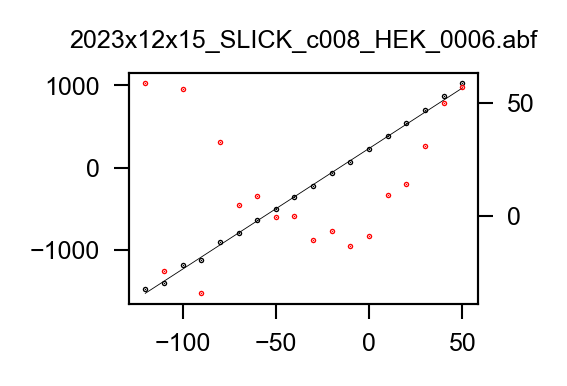

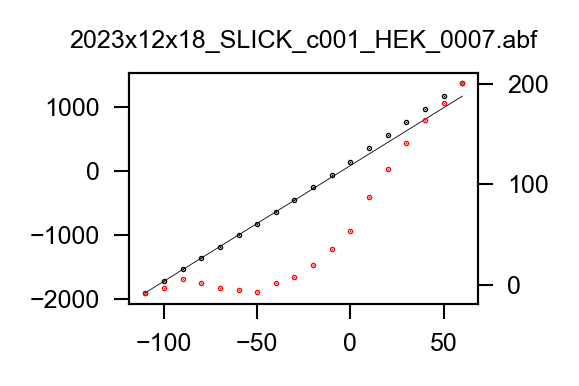

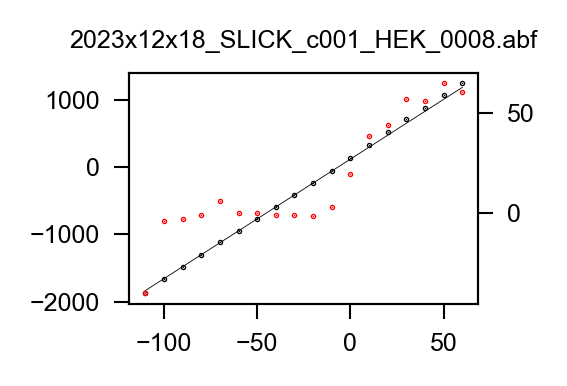

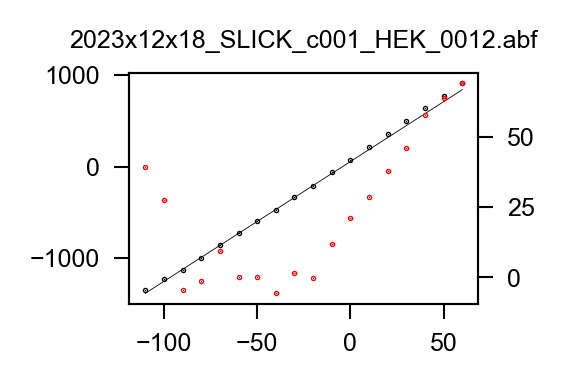

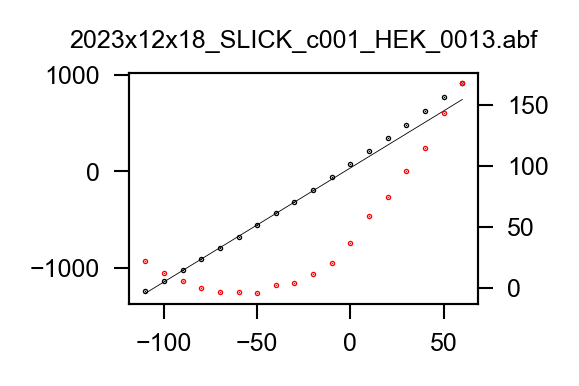

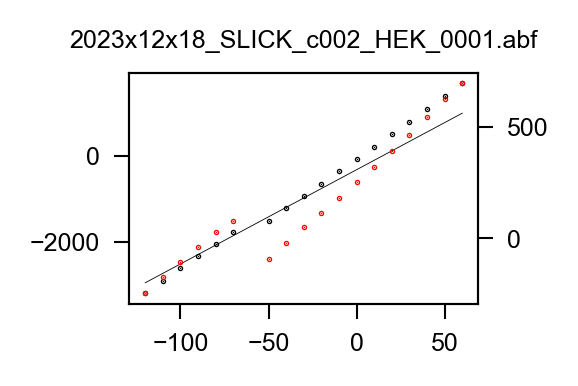

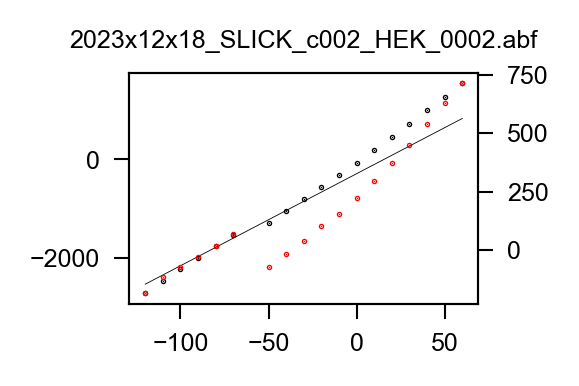

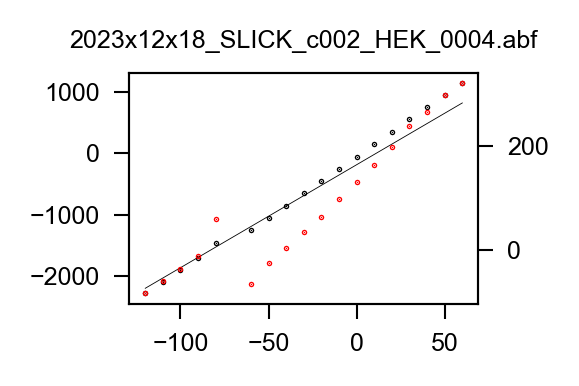

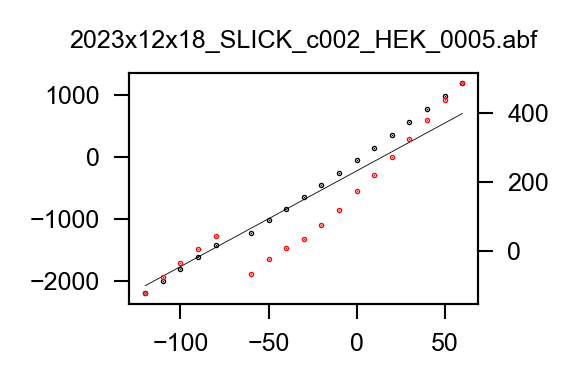

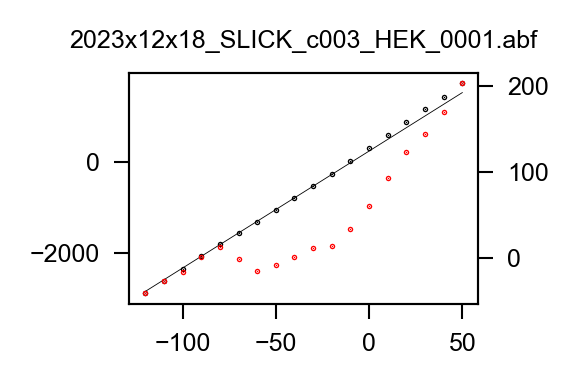

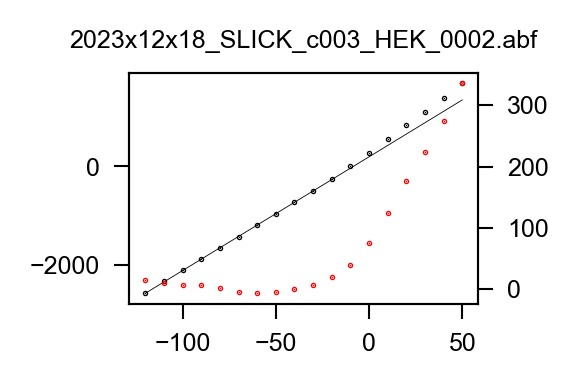

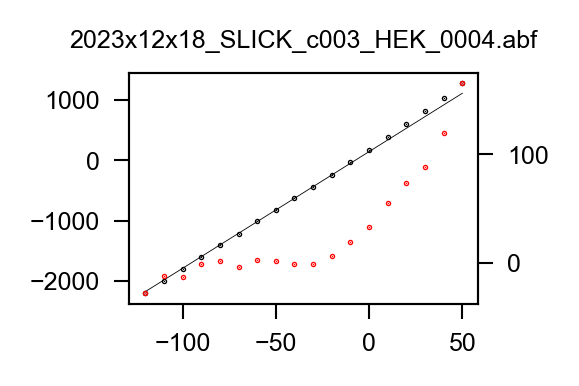

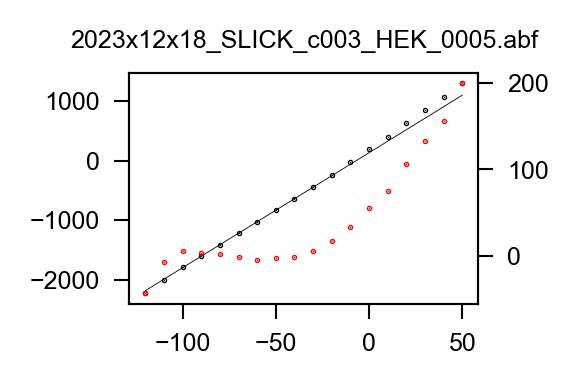

In [8]:
to_plot = True
results_list = list()
for rec in abf_recordings_df.index:
    abf = pyabf.ABF(rec)
    sweep_results = measure_slick(abf,duration_ms = 10,to_plot=True)
    if abf_recordings_df.loc[rec,'protocol'] == 'K_total':
        abf = pyabf.ABF(rec)
        sweep_results = linear_leak_correction(sweep_results)
        fig_leak,ax= plt.subplots(1,figsize=(1.5,1),dpi=300)
        ax.scatter(sweep_results['Vm'],sweep_results['Ik'],c='k',s=.1)
        ax.plot(sweep_results['Vm'],sweep_results['I_leak'],'k',linewidth=.2)
        ax.twinx().scatter(sweep_results['Vm'],sweep_results['Ik_corr'],c='r',s=.1)
        name=rec.split('/')[-1]
        ax.set_title(name)
        fig_leak.savefig(f"./figs/{name}_LEAK.svg", format='svg',bbox_inches='tight')

    results_list.append(sweep_results)
abf_recordings_df['K_Currents']=results_list

In [9]:
before_data =list()
for cell_rec in doses_df['Before IV'].values:
    for rec in abf_recordings_df.index:
        if str(cell_rec) in rec:
            before_data.append(abf_recordings_df.loc[rec,'K_Currents'])
doses_df['Before'] = before_data


after_data =list()
for cell_rec in doses_df['After IV'].values:
    for rec in abf_recordings_df.index:
        if str(cell_rec) in rec:
            after_data.append(abf_recordings_df.loc[rec,'K_Currents'])
doses_df['After'] = after_data

display(doses_df.head())

,Before IV,During,After IV,Before,After
Cell,,,,,
2023x12x13_SLICK_c001_HEK,2023x12x13_SLICK_c001_HEK_0002,2023x12x13_SLICK_c001_HEK_0003,2023x12x13_SLICK_c001_HEK_0004,"{'Ik': [-494.0796, -458.6792, -399.4751, -369....","{'Ik': [-772.7051, -707.70264, -603.02734, -51..."
2023x12x13_SLICK_c002_HEK,2023x12x13_SLICK_c002_HEK_0004,2023x12x13_SLICK_c002_HEK_0006,2023x12x13_SLICK_c002_HEK_0008,"{'Ik': [-72.32666, -67.74902, -54.93164, -48.8...","{'Ik': [-194.39697, -160.52246, -156.55518, -1..."
2023x12x14_SLICK_c001_HEK,2023x12x14_SLICK_c001_HEK_0000,2023x12x14_SLICK_c001_HEK_0002,2023x12x14_SLICK_c001_HEK_0003,"{'Ik': [-1480.1025, -1348.2666, -1216.4307, -1...","{'Ik': [-1702.2705, -1559.1431, -1394.6533, -1..."
2023x12x15_SLICK_c001_HEK,2023x12x15_SLICK_c001_HEK_0003,2023x12x15_SLICK_c001_HEK_0004,2023x12x15_SLICK_c001_HEK_0005,"{'Ik': [-589.5996, -513.0005, -450.74463, -388...","{'Ik': [-379.02832, -353.69873, -306.39648, -2..."
2023x12x15_SLICK_c002_HEK,2023x12x15_SLICK_c002_HEK_0002,2023x12x15_SLICK_c002_HEK_0003,2023x12x15_SLICK_c002_HEK_0004,"{'Ik': [-2253.418, -2008.3618, -1755.9814, -14...","{'Ik': [-1978.7598, -1765.1367, -1549.6826, -1..."


In [10]:
doses_df['delta']=pd.Series
for r in doses_df.index:
    before = doses_df.loc[r,'Before']
    max_I = np.max(before['Ik_corr'])
    before['Ik_norm'] = before['Ik_corr'] / max_I
    doses_df.at[r,'Before'] = before

    after = doses_df.loc[r,'After']
    after['Ik_norm'] = after['Ik_corr'] / max_I
    doses_df.at[r,'After'] = after

    common = sorted(list(set(after['Vm']).intersection(set(before['Vm']))))

    delta = {'Vm':common,'Ikb':list(),'Ika':list()}

    for i,v in enumerate(before['Vm']):
        if v in delta['Vm']:
            delta['Ikb'].append( before['Ik_norm'][i] )

    for i,v in enumerate(after['Vm']):
        if v in delta['Vm']:
            delta['Ika'].append( after['Ik_norm'][i] )
    doses_df.at[r,'delta'] = delta


In [11]:
Ik_after=pd.DataFrame()
Ik_before=pd.DataFrame()
for c in doses_df.index:
    Ik_before[c] = pd.DataFrame(doses_df.loc[c,'delta']).set_index('Vm')['Ikb']
    Ik_after[c] = pd.DataFrame(doses_df.loc[c,'delta']).set_index('Vm')['Ika']

Ik_after.to_csv('Normalized_IV_10uM.csv')
Ik_before.to_csv('Normalized_IV_Before.csv')
from google import colab
colab.files.download('Normalized_IV_10uM.csv')
colab.files.download('Normalized_IV_Before.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

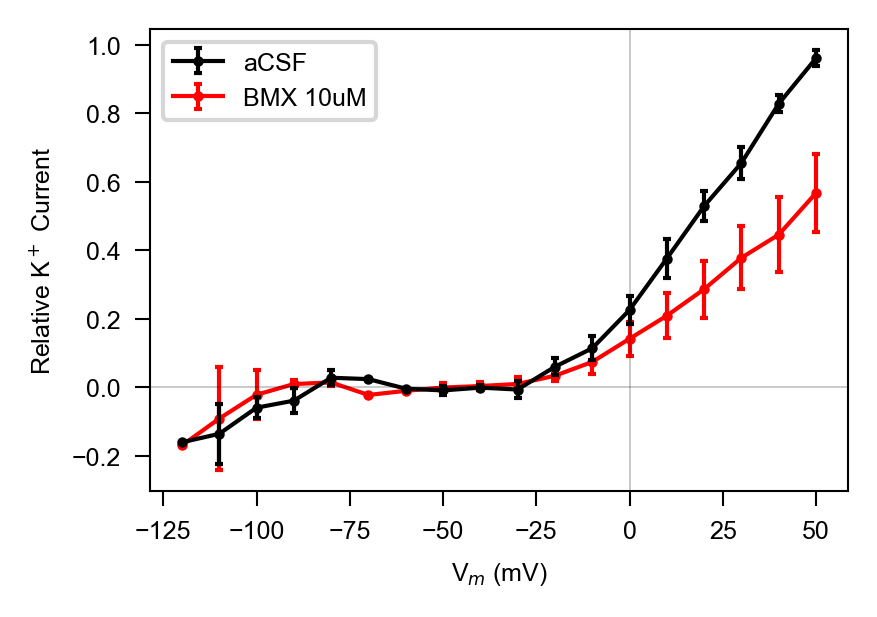

In [16]:
fig_IV_block,ax=plt.subplots(1,dpi=300,figsize=(3,2))
ax.errorbar(Ik_after.index,
            np.mean(Ik_before.T),
            yerr = scipy.stats.sem(Ik_before,axis=1),fmt ='.-',
            markersize=3, c='k',
            linewidth=1,
            capsize=1,
            label='aCSF')

ax.errorbar(Ik_after.index,
            np.mean(Ik_after.T),
            yerr = scipy.stats.sem(Ik_after,axis=1),fmt ='.-',
            markersize=3, c='r',
            linewidth=1,
            capsize=1,zorder=0,
            label='BMX 10uM')
ax.axhline(0,linewidth=.1,color='k')
ax.axvline(0,linewidth=.1,color='k')
plt.legend()
ax.set_ylabel('Relative K$^+$ Current')
ax.set_xlabel('V$_m$ (mV)')
# ax.spines['left'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('zero')
# ax.spines['top'].set_color('none')
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')
fig_IV_block.savefig('./figs/fig_IV_block.svg',format='svg',bbox_inches='tight')
colab.files.download('./figs/fig_IV_block.svg')

In [13]:
def slick_sub(abf):
    duration_ms =10
    duration_indx = int(duration_ms/1000*abf.sampleRate)

    abf = pyabf.ABF(file_loc)
    measure_epoch_1 = get_epoch(abf,epoch=1)
    abf = pyabf.ABF(file_loc)
    measure_epoch_2 = get_epoch(abf,epoch=2)
    abf = pyabf.ABF(file_loc)
    measure_epoch_3 = get_epoch(abf,epoch=3)

    I_1,V_1,T = analyze_currents(abf,measure_epoch_1['index']["stop"]-duration_indx,measure_epoch_1['index']["stop"],i_chan=0)
    I_2,V_2,T = analyze_currents(abf,measure_epoch_2['index']["stop"]-duration_indx,measure_epoch_2['index']["stop"],i_chan=0)
    I_3,V_3,T = analyze_currents(abf,measure_epoch_3['index']["stop"]-duration_indx,measure_epoch_3['index']["stop"],i_chan=0)

    dv_2 = np.array(V_2) - np.array(V_1)
    dv_3 = np.array(V_3) - np.array(V_1)
    di_2 = np.array(I_2) - np.array(I_1)
    L = di_2*(dv_3/dv_2)  + I_1
    I_corr = I_3-L
    return (I_corr,V_3,T)

In [14]:
wash_in_data=list()
for c in doses_df.index:
    rec_id = doses_df.loc[c,'During']
    file_loc = [f for f in abf_recordings_df.index if rec_id in f][0]
    doses_df.loc[c,'ABF'] = file_loc
    abf = pyabf.ABF(file_loc)

    duration_ms = 10
    duration_indx = int(duration_ms/1000*abf.sampleRate)
    measure_epoch = get_epoch(abf,epoch=3)
    stop_idx = measure_epoch['index']["stop"]
    start_idx = stop_idx - duration_indx

    if 2 not in abf.channelList:
        I,V,T = analyze_currents(abf,start_idx,stop_idx,i_chan=0)
        I = [i*np.nan for i in I]
    if 2 in abf.channelList:
        I,V,T = analyze_currents(abf,start_idx,stop_idx,i_chan=2)
        trace = {"current":I,"Vm":V,"Time":T}

    wash_in_data.append(I/np.mean(I[:4]))
doses_df['wash_in_data']=wash_in_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

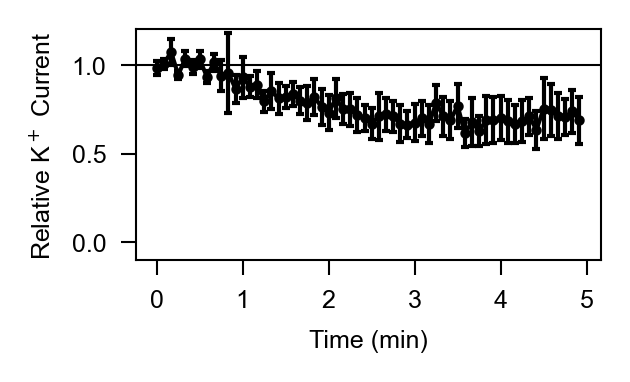

In [18]:
skip_list = ['2023x12x14_SLICK_c001_HEK','2023x12x15_SLICK_c003_HEK',]
# skip_list=[]
wash_in_df=pd.DataFrame()
for c in doses_df.index:
    if c not in skip_list:
        wash_in_df[c] = pd.DataFrame(doses_df.loc[c,'wash_in_data'])


fig_wash_in,ax = plt.subplots(1,figsize=(2,1))
x = wash_in_df.index*5/60
y = np.nanmean(wash_in_df,axis=1)
err = scipy.stats.sem(wash_in_df,axis=1,nan_policy='omit')

ax.errorbar(x,
            y,
            yerr = err,
            fmt ='.-',
            markersize=3, c='k',
            linewidth=1,
            capsize=1)
ax.axhline(1,color='k',linewidth=.5)
ax.set_ylim(-.1,1.2)
wash_in_df.to_csv('wash_in_df.csv')
colab.files.download('wash_in_df.csv')
ax.set_ylabel('Relative K$^+$ Current')
ax.set_xlabel('Time (min)')
fig_wash_in.savefig("./figs/fig_wash_in.svg", format='svg',bbox_inches='tight')
colab.files.download('./figs/fig_wash_in.svg')